# Xpand IT DS Challenge

This notebook contains the template you should use to present your code, results and conclusions. You should keep the main structure intact to make it easier to evaluate and compare in the end.

## Dataset
You can find the dataset in the data folder of the repository. The folder contains two files:
* dow_jones_index.data - dataset data
* dow_jones_index.names - dataset information and details

### Data Importation

## Business Analysis
Here you should conduct a brief analysis of what is Dow Jones Index. You can enumerate the main topics to take into account based on the dataset provided as well as your understandings of the variables.


-----
*Add here your business analysis conclusions (max. 200 words)*

-----


Project Goal: 
- Predict what will be the best company to invest each week. 
- This can be translated into determining which stock will produce the greatest rate of return in the following week.
- Dependent variable (y): percent_change_next_weeks_price -> I intend to predict the stock that will have the highest percent_change_next_weeks_price.

Multivariate time series composed by several stocks (30 in total).

[Key Words]:
 - Time Series
 - Stock Prices
 - Prediction
 - LSTMs (Long Short Term Memory) - often refered in the literature
 - ARIMA / SARIMA (Auto Regressive Integrated Moving Average) / (Seasonal Auto Regressive Integrated Moving Average) - Baseline method

References:
1. https://archive.ics.uci.edu/dataset/312/dow+jones+index
2. https://www.semanticscholar.org/paper/Dynamic-Radius-Species-Conserving-Genetic-Algorithm-Brown-Pelosi/24d692e537b28b1fd13a18c0c93f0df6ef4e2047
3. https://neptune.ai/blog/predicting-stock-prices-using-machine-learning
4. https://www.researchgate.net/publication/268513448_Weekly_Dow_Jones_Index_Data

Other resources:
5. https://rpubs.com/AbhaJha/984077

## Data Understanding
During the data understanding phase, you should focus on understanding what each variable represents, compute statistics and visualizations. Some questions that may guide your work follow:
* Feature engineering: should new features be created from the existing ones?
* What will be your features and your label?
* Is the dataset ready for the prediction task? (ex: missing values)
* How will the data be split into train and test sets?

-----

In [403]:
#Libraries

# Data Exploration
import pandas as pd
import os
import numpy as np
import statistics as stats
import matplotlib.pyplot as plt
from scipy import stats

# Feature Selection
import seaborn as sns
import statsmodels.api as sm
from itertools import combinations
from sklearn.feature_selection import mutual_info_regression
from collections import defaultdict

# Modelling
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import itertools
from collections import Counter

In [2]:
path = os.getcwd()
print(path)

c:\Users\Carolina\Desktop\CV\Python_challenges\DSU-Recruitment-Challenges


In [3]:
#add here your imports

# Read and close the file with with open()
with open(path +'\\data\\dow_jones_index.data','r') as data_file:
    # Define the column names (given by the 1st row of the data_file) 
    column_names = data_file.readline().strip().split(',')

    #Self-note: Once the first row is already been read and processed to obtain the column names, no need to do next(data_file), or it would skip the 1st row of values.

    # Create a nested array to store each row values 
    data_values = [row.strip().split(',') for row in data_file]
    
# Create a dataframe with the data
df = pd.DataFrame(data_values, columns=column_names)
df

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,$15.82,$16.72,$15.78,$16.42,239655616,3.79267,,,$16.71,$15.97,-4.42849,26,0.182704
1,1,AA,1/14/2011,$16.71,$16.71,$15.64,$15.97,242963398,-4.42849,1.380223028,239655616,$16.19,$15.79,-2.47066,19,0.187852
2,1,AA,1/21/2011,$16.19,$16.38,$15.60,$15.79,138428495,-2.47066,-43.02495926,242963398,$15.87,$16.13,1.63831,12,0.189994
3,1,AA,1/28/2011,$15.87,$16.63,$15.82,$16.13,151379173,1.63831,9.355500109,138428495,$16.18,$17.14,5.93325,5,0.185989
4,1,AA,2/4/2011,$16.18,$17.39,$16.18,$17.14,154387761,5.93325,1.987451735,151379173,$17.33,$17.37,0.230814,97,0.175029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,2,XOM,5/27/2011,$80.22,$82.63,$80.07,$82.63,68230855,3.00424,-21.35571346,86758820,$83.28,$81.18,-2.52161,75,0.568801
746,2,XOM,6/3/2011,$83.28,$83.75,$80.18,$81.18,78616295,-2.52161,15.2210316,68230855,$80.93,$79.78,-1.42098,68,0.57896
747,2,XOM,6/10/2011,$80.93,$81.87,$79.72,$79.78,92380844,-1.42098,17.50851907,78616295,$80.00,$79.02,-1.225,61,0.58912
748,2,XOM,6/17/2011,$80.00,$80.82,$78.33,$79.02,100521400,-1.225,8.8119524,92380844,$78.65,$76.78,-2.37762,54,0.594786


In [4]:
#add here your data understanting code

## Initial dataset inspection
 - General Information
 - Missing values

#### General Info

In [5]:
#Print information relative to df
df.info() # all variables are object Stype, i.e., str 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   quarter                             750 non-null    object
 1   stock                               750 non-null    object
 2   date                                750 non-null    object
 3   open                                750 non-null    object
 4   high                                750 non-null    object
 5   low                                 750 non-null    object
 6   close                               750 non-null    object
 7   volume                              750 non-null    object
 8   percent_change_price                750 non-null    object
 9   percent_change_volume_over_last_wk  750 non-null    object
 10  previous_weeks_volume               750 non-null    object
 11  next_weeks_open                     750 non-null    object

In [6]:
#Remove the $ sign from the data cells -> this is insufficient to convert str to numerical feature
df = df.applymap(lambda x: x.replace('$', '') if isinstance(x, str) else x)
df

C:\Users\Carolina\AppData\Local\Temp\ipykernel_20864\3616501523.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.replace('$', '') if isinstance(x, str) else x)


,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,15.82,16.72,15.78,16.42,239655616,3.79267,,,16.71,15.97,-4.42849,26,0.182704
1,1,AA,1/14/2011,16.71,16.71,15.64,15.97,242963398,-4.42849,1.380223028,239655616,16.19,15.79,-2.47066,19,0.187852
2,1,AA,1/21/2011,16.19,16.38,15.60,15.79,138428495,-2.47066,-43.02495926,242963398,15.87,16.13,1.63831,12,0.189994
3,1,AA,1/28/2011,15.87,16.63,15.82,16.13,151379173,1.63831,9.355500109,138428495,16.18,17.14,5.93325,5,0.185989
4,1,AA,2/4/2011,16.18,17.39,16.18,17.14,154387761,5.93325,1.987451735,151379173,17.33,17.37,0.230814,97,0.175029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,2,XOM,5/27/2011,80.22,82.63,80.07,82.63,68230855,3.00424,-21.35571346,86758820,83.28,81.18,-2.52161,75,0.568801
746,2,XOM,6/3/2011,83.28,83.75,80.18,81.18,78616295,-2.52161,15.2210316,68230855,80.93,79.78,-1.42098,68,0.57896
747,2,XOM,6/10/2011,80.93,81.87,79.72,79.78,92380844,-1.42098,17.50851907,78616295,80.00,79.02,-1.225,61,0.58912
748,2,XOM,6/17/2011,80.00,80.82,78.33,79.02,100521400,-1.225,8.8119524,92380844,78.65,76.78,-2.37762,54,0.594786


In [7]:
#The dataset has blank spaces on some data cells (given by '' in Python). Need to turn them into NaN first.
df.replace('', np.nan, inplace=True)
#Now that df has NaN instead of '', let us provide the number of NaNs per column
df.isna().sum()

quarter                                0
stock                                  0
date                                   0
open                                   0
high                                   0
low                                    0
close                                  0
volume                                 0
percent_change_price                   0
percent_change_volume_over_last_wk    30
previous_weeks_volume                 30
next_weeks_open                        0
next_weeks_close                       0
percent_change_next_weeks_price        0
days_to_next_dividend                  0
percent_return_next_dividend           0
dtype: int64

In [8]:
# Convert Numerical cols to Numerics and Date to Date
# 1. Numerical_cols_index will be a list with the indexes of the columns that will be converted to numerical features
numerical_cols_index = list(np.concatenate(([0], np.arange(3, 15)))) #list to provide commas between values (otherwise would be an array of numbers only)

# Convert selected columns to the 'category' data type
df.iloc[:, numerical_cols_index] = df.iloc[:, numerical_cols_index].astype('float')

# 2. Date column
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   quarter                             750 non-null    object        
 1   stock                               750 non-null    object        
 2   date                                750 non-null    datetime64[ns]
 3   open                                750 non-null    object        
 4   high                                750 non-null    object        
 5   low                                 750 non-null    object        
 6   close                               750 non-null    object        
 7   volume                              750 non-null    object        
 8   percent_change_price                750 non-null    object        
 9   percent_change_volume_over_last_wk  720 non-null    object        
 10  previous_weeks_volume     

#### MVs

 - The MVs are on columns (i) percent_change_volume_over_last_wk and (ii) previous_weeks_volume.
 - According to the file dow_jones_index.names, the variables are described as follows:
    1. previous_weeks_volume: the number of shares of stock that traded hands in the previous week.
    2. percent_change_volume_over_last_wk: the percentage change in the number of shares of stock that traded hands for this week compared to the previous week

##### Variable 'previous_weeks_volume' MVs' imputation

In [9]:
# The variable previous_weeks_volume can be obtained based on the previous week 'volume' variable value.
# Closer inspection at the variables 'previous_weeks_volume' and 'volume'
df[['previous_weeks_volume', 'volume']].head()

,previous_weeks_volume,volume
0,NaN,239655616.0
1,239655616.0,242963398.0
2,242963398.0,138428495.0
3,138428495.0,151379173.0
4,151379173.0,154387761.0


In [10]:
# We can use .fillna() and shift() to achieve the desired outcome.
# Fill NaNs in 'previous_weeks_volume' with values from 'volume' shifted by one index -> This will not work on the first MVs, as there are no previous volume recordd.
df['previous_weeks_volume'].fillna(df['volume'].shift(), inplace=True)
df[['previous_weeks_volume', 'volume']].head()

,previous_weeks_volume,volume
0,NaN,239655616.0
1,239655616.0,242963398.0
2,242963398.0,138428495.0
3,138428495.0,151379173.0
4,151379173.0,154387761.0


How to impute the reamining MV (at the beginning of the dataset)
 - Quicker Possibilities:
    1. Mean - viable if the values follow a Normal Distribution and there are no outliers (as mean is not robust against outliers)
    2. Median - viable if the distribution is skewed or there are outliers
 - Try, if there is time:
    3. K-NN

In [11]:
def assess_normality(column_values):
    # Create a figure to plot 2 plots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot histogram on the first axis
    axs[0].hist(column_values, bins=20, color='skyblue', edgecolor='black')
    axs[0].set_xlabel('Volume')
    axs[0].set_ylabel('Frequency')
    axs[0].set_title('Distribution of Volume')

    # Plot box plot on the second axis
    axs[1].boxplot(column_values, vert=False)
    axs[1].set_xlabel('Volume')
    axs[1].set_title('Box Plot of Volume')

    # Adjust layout
    plt.tight_layout()

    plt.show()

    # Perform Shapiro-Wilk test. H0: The data provides from a Normal Distribution
    statistic, p_value = stats.shapiro(column_values)
    #print(f'The Shapiro-Wilk Test statistic value is {statistic} and the p-value is {p_value}')

    # Define the usual significance level, alpha =5%
    alpha = 0.05
    # p-value measures the probability of obtaining the observed results, assuming that the null hypothesis is true.
    # The lower the p-value, thw the probability of obtaining the observed results, assuming that the null hypothesis is true.
    # The lower the p-value, the greater the statistical significance to reject H0.
    if p_value < alpha:
        print(f"The p-value {p_value} is lower than the significance level {alpha}. \nHence, there is statistical significance to reject H0, i.e., the data does not appear to be normally distributed.")
    else:
        print(f"The p-value {p_value} is greater than, or equal to, the significance level {alpha}. \nHence, there is not statistical significance to reject H0, i.e., the data appears to be normally distributed.")

In [12]:
# Save non-NaN observations of previous_weeks_volume into prev_weeks_vol_data series
prev_weeks_vol_data=df.dropna(subset=['previous_weeks_volume'])['previous_weeks_volume']

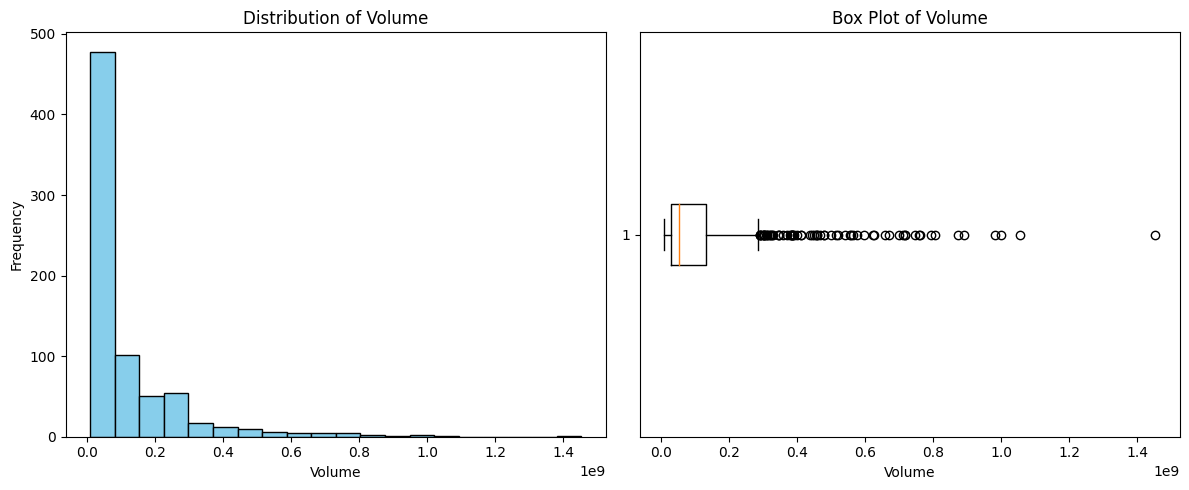

The p-value 2.2177548131108515e-37 is lower than the significance level 0.05. 
Hence, there is statistical significance to reject H0, i.e., the data does not appear to be normally distributed.


In [13]:
#Assess the distribution (and normality) of the desired column: prev_weeks_vol_data
assess_normality(prev_weeks_vol_data)

In [14]:
#The previous assessment leads to the imputation of the remaining MV of previous_weeks_volume with the median value of the variable. 
df['previous_weeks_volume'].fillna(df['previous_weeks_volume'].median(), inplace=True)
df.head()

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1.0,AA,2011-01-07,15.82,16.72,15.78,16.42,239655616.0,3.79267,NaN,52758908.0,16.71,15.97,-4.42849,26.0,0.182704
1,1.0,AA,2011-01-14,16.71,16.71,15.64,15.97,242963398.0,-4.42849,1.380223,239655616.0,16.19,15.79,-2.47066,19.0,0.187852
2,1.0,AA,2011-01-21,16.19,16.38,15.6,15.79,138428495.0,-2.47066,-43.024959,242963398.0,15.87,16.13,1.63831,12.0,0.189994
3,1.0,AA,2011-01-28,15.87,16.63,15.82,16.13,151379173.0,1.63831,9.3555,138428495.0,16.18,17.14,5.93325,5.0,0.185989
4,1.0,AA,2011-02-04,16.18,17.39,16.18,17.14,154387761.0,5.93325,1.987452,151379173.0,17.33,17.37,0.230814,97.0,0.175029


##### Variable 'percent_change_volume_over_last_week' MVs' imputation
 - percent_change_volume_over_last_wk: the percentage change in the number of shares of stock that traded hands for this week compared to the previous week

In [15]:
#We need volume variable again :)
#recall -> volume: the number of shares of stock that traded hands in the week
df[['volume', 'percent_change_volume_over_last_wk']]

,volume,percent_change_volume_over_last_wk
0,239655616.0,NaN
1,242963398.0,1.380223
2,138428495.0,-43.024959
3,151379173.0,9.3555
4,154387761.0,1.987452
...,...,...
745,68230855.0,-21.355713
746,78616295.0,15.221032
747,92380844.0,17.508519
748,100521400.0,8.811952


In [16]:
# Calculate the percentage change for each row where 'percent_change_volume_over_last_wk' is NaN
for i, row in df.iterrows():
    if i>0 and pd.isna(row['percent_change_volume_over_last_wk']):
        current_volume = row['volume']
        previous_volume = df.at[i - 1, 'volume']  # Get the volume from the previous row
        #"Regra de 3 simples" to reach the corresponding percentage of the new week, compared to the old. Need to remove the old week value: will be 100%
        percent_change = ((current_volume*100) / previous_volume) - 100
        df.at[i, 'percent_change_volume_over_last_wk'] = percent_change
df[['volume', 'percent_change_volume_over_last_wk']].head()

,volume,percent_change_volume_over_last_wk
0,239655616.0,NaN
1,242963398.0,1.380223
2,138428495.0,-43.024959
3,151379173.0,9.3555
4,154387761.0,1.987452


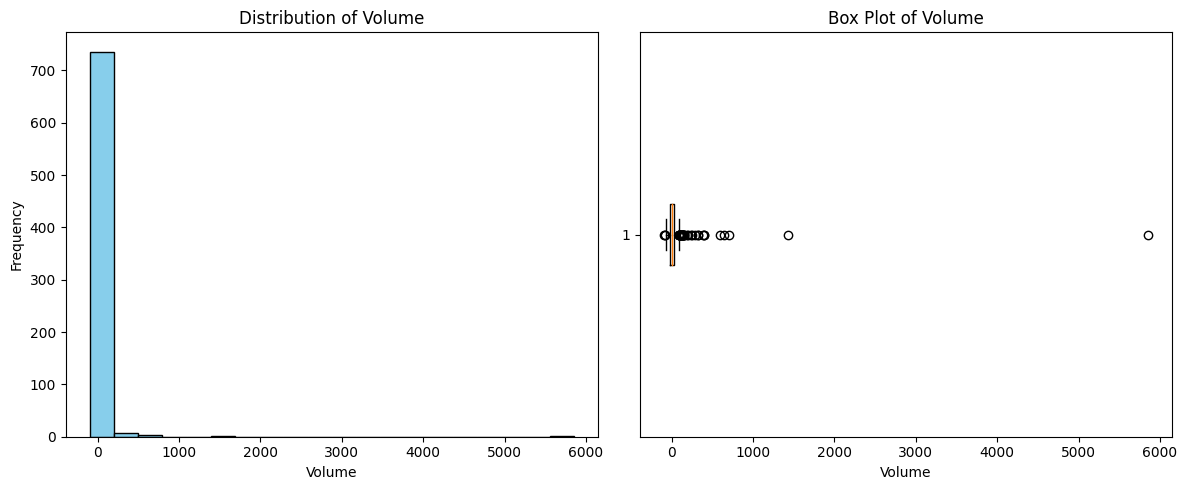

The p-value 0.0 is lower than the significance level 0.05. 
Hence, there is statistical significance to reject H0, i.e., the data does not appear to be normally distributed.


In [17]:
# Save non-NaN observations of previous_weeks_volume into prev_weeks_vol_data series
percent_change_volume_over_last_wk_data=df.dropna(subset=['percent_change_volume_over_last_wk'])['percent_change_volume_over_last_wk']

#Assess the distribution (and normality) of the desired column: prev_weeks_vol_data
assess_normality(percent_change_volume_over_last_wk_data)

In [18]:
#The previous assessment leads to the imputation of the remaining MV of previous_weeks_volume with the median value of the variable. 
df['percent_change_volume_over_last_wk'].fillna(df['percent_change_volume_over_last_wk'].median(), inplace=True)
df.head()

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1.0,AA,2011-01-07,15.82,16.72,15.78,16.42,239655616.0,3.79267,0.934330,52758908.0,16.71,15.97,-4.42849,26.0,0.182704
1,1.0,AA,2011-01-14,16.71,16.71,15.64,15.97,242963398.0,-4.42849,1.380223,239655616.0,16.19,15.79,-2.47066,19.0,0.187852
2,1.0,AA,2011-01-21,16.19,16.38,15.6,15.79,138428495.0,-2.47066,-43.024959,242963398.0,15.87,16.13,1.63831,12.0,0.189994
3,1.0,AA,2011-01-28,15.87,16.63,15.82,16.13,151379173.0,1.63831,9.355500,138428495.0,16.18,17.14,5.93325,5.0,0.185989
4,1.0,AA,2011-02-04,16.18,17.39,16.18,17.14,154387761.0,5.93325,1.987452,151379173.0,17.33,17.37,0.230814,97.0,0.175029


In [19]:
# Fix the object dtypes -> numerical columns to numeric
numerical_cols = [col for col in df.columns if col not in ['stock', 'date']]

# Convert selected columns to numeric
df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric, errors='coerce')

In [20]:
#Assess if the conversion was succeeded -> it was!
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   quarter                             750 non-null    float64       
 1   stock                               750 non-null    object        
 2   date                                750 non-null    datetime64[ns]
 3   open                                750 non-null    float64       
 4   high                                750 non-null    float64       
 5   low                                 750 non-null    float64       
 6   close                               750 non-null    float64       
 7   volume                              750 non-null    float64       
 8   percent_change_price                750 non-null    float64       
 9   percent_change_volume_over_last_wk  750 non-null    float64       
 10  previous_weeks_volume     

### Variable Derivation 


In [21]:
numerical_cols

['quarter',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'percent_change_price',
 'percent_change_volume_over_last_wk',
 'previous_weeks_volume',
 'next_weeks_open',
 'next_weeks_close',
 'percent_change_next_weeks_price',
 'days_to_next_dividend',
 'percent_return_next_dividend']

In [22]:
# 1. Price Change Ratios
df['price_change_ratio'] = df['close'] / df['close'].shift(1)

# 2. Calendar-related Features
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month

# 3. Volume-based Features
df['volume_to_avg_volume_ratio'] = df['volume'] / df['previous_weeks_volume']

''' 
# 4. Volatility Measures (using standard deviation)
window = 7  # Can be adjusted as intended
df['volatility'] = df['close'].rolling(window=window).std()

# 5. Relative Strength Index (RSI)
# Intermediate Calcs
# Calculate price changes
df['price_change'] = df['close'] - df['close'].shift(1)
# Calculate gains and losses
df['gain'] = df['price_change'].apply(lambda x: x if x > 0 else 0)
df['loss'] = df['price_change'].apply(lambda x: abs(x) if x < 0 else 0)
# Calculate average gains and losses over a specified time period
window = 14  # Can be adjusted as intended
df['average_gain'] = df['gain'].rolling(window=window).mean()
df['average_loss'] = df['loss'].rolling(window=window).mean()

# Calculate relative strength (RS) and relative strength index (RSI)
df['relative_strength'] = df['average_gain'] / df['average_loss']
df['rsi'] = 100 - (100 / (1 + df['relative_strength']))

# 6. Moving Averages (weekly, 15-day, and monthly moving averages)
df['weekly_ma'] = df['close'].rolling(window=7).mean()
df['quinzenal_ma'] = df['close'].rolling(window=15).mean()
df['monthly_ma'] = df['close'].rolling(window=30).mean()

# Drop intermediate columns used for RSI calculation
df.drop(['price_change', 'gain', 'loss', 'average_gain', 'average_loss', 'relative_strength'], axis=1, inplace=True)
'''
df.head()

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend,price_change_ratio,day_of_week,month,volume_to_avg_volume_ratio
0,1.0,AA,2011-01-07,15.82,16.72,15.78,16.42,239655616.0,3.79267,0.934330,52758908.0,16.71,15.97,-4.428490,26.0,0.182704,NaN,4,1,4.542467
1,1.0,AA,2011-01-14,16.71,16.71,15.64,15.97,242963398.0,-4.42849,1.380223,239655616.0,16.19,15.79,-2.470660,19.0,0.187852,0.972594,4,1,1.013802
2,1.0,AA,2011-01-21,16.19,16.38,15.60,15.79,138428495.0,-2.47066,-43.024959,242963398.0,15.87,16.13,1.638310,12.0,0.189994,0.988729,4,1,0.569750
3,1.0,AA,2011-01-28,15.87,16.63,15.82,16.13,151379173.0,1.63831,9.355500,138428495.0,16.18,17.14,5.933250,5.0,0.185989,1.021533,4,1,1.093555
4,1.0,AA,2011-02-04,16.18,17.39,16.18,17.14,154387761.0,5.93325,1.987452,151379173.0,17.33,17.37,0.230814,97.0,0.175029,1.062616,4,2,1.019875


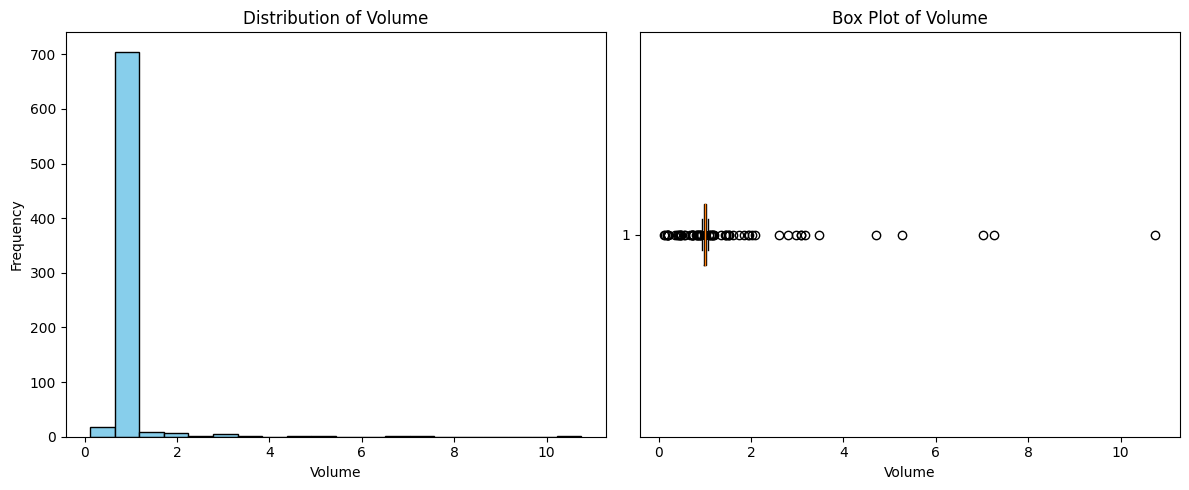

The p-value 0.0 is lower than the significance level 0.05. 
Hence, there is statistical significance to reject H0, i.e., the data does not appear to be normally distributed.


In [23]:
# Save non-NaN observations of previous_weeks_volume into prev_weeks_vol_data series
percent_change_volume_over_last_wk_data=df.dropna(subset=['price_change_ratio'])['price_change_ratio']

#Assess the distribution (and normality) of the desired column: prev_weeks_vol_data
assess_normality(percent_change_volume_over_last_wk_data)

In [24]:
#The previous assessment leads to the imputation of the remaining MV of previous_weeks_volume with the median value of the variable. 
df['price_change_ratio'].fillna(df['price_change_ratio'].median(), inplace=True)
df.head()

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend,price_change_ratio,day_of_week,month,volume_to_avg_volume_ratio
0,1.0,AA,2011-01-07,15.82,16.72,15.78,16.42,239655616.0,3.79267,0.934330,52758908.0,16.71,15.97,-4.428490,26.0,0.182704,0.999038,4,1,4.542467
1,1.0,AA,2011-01-14,16.71,16.71,15.64,15.97,242963398.0,-4.42849,1.380223,239655616.0,16.19,15.79,-2.470660,19.0,0.187852,0.972594,4,1,1.013802
2,1.0,AA,2011-01-21,16.19,16.38,15.60,15.79,138428495.0,-2.47066,-43.024959,242963398.0,15.87,16.13,1.638310,12.0,0.189994,0.988729,4,1,0.569750
3,1.0,AA,2011-01-28,15.87,16.63,15.82,16.13,151379173.0,1.63831,9.355500,138428495.0,16.18,17.14,5.933250,5.0,0.185989,1.021533,4,1,1.093555
4,1.0,AA,2011-02-04,16.18,17.39,16.18,17.14,154387761.0,5.93325,1.987452,151379173.0,17.33,17.37,0.230814,97.0,0.175029,1.062616,4,2,1.019875


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   quarter                             750 non-null    float64       
 1   stock                               750 non-null    object        
 2   date                                750 non-null    datetime64[ns]
 3   open                                750 non-null    float64       
 4   high                                750 non-null    float64       
 5   low                                 750 non-null    float64       
 6   close                               750 non-null    float64       
 7   volume                              750 non-null    float64       
 8   percent_change_price                750 non-null    float64       
 9   percent_change_volume_over_last_wk  750 non-null    float64       
 10  previous_weeks_volume     

### Statistics, Insights, and Data Visualization

In [26]:
df.describe()

,quarter,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend,price_change_ratio,day_of_week,month,volume_to_avg_volume_ratio
count,750.000000,750,750.000000,750.000000,750.000000,750.000000,7.500000e+02,750.000000,750.000000,7.500000e+02,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.00000,750.000000,750.000000
mean,1.520000,2011-03-31 23:02:24,53.651840,54.669987,52.640160,53.729267,1.175478e+08,0.050262,19.607898,1.168275e+08,53.702440,53.889080,0.238468,52.525333,0.691826,1.054185,3.96000,3.520000,1.200790
min,1.000000,2011-01-07 00:00:00,10.590000,10.940000,10.400000,10.520000,9.718851e+06,-15.422900,-96.636950,9.718851e+06,10.520000,10.520000,-15.422900,0.000000,0.065574,0.119464,3.00000,1.000000,0.033630
25%,1.000000,2011-02-18 00:00:00,29.830000,30.627500,28.720000,30.365000,3.086624e+07,-1.288053,-20.220722,3.063918e+07,30.315000,30.462500,-1.222068,24.000000,0.534549,0.982855,4.00000,2.000000,0.797793
50%,2.000000,2011-04-01 00:00:00,45.970000,46.885000,44.800000,45.930000,5.306088e+07,0.000000,0.934330,5.275891e+07,46.015000,46.125000,0.101193,47.000000,0.681067,0.999038,4.00000,4.000000,1.009571
75%,2.000000,2011-05-13 00:00:00,72.715000,74.287500,71.037500,72.667500,1.327218e+08,1.650888,23.063086,1.327218e+08,72.715000,72.915000,1.845562,69.000000,0.854291,1.017748,4.00000,5.000000,1.232131
max,2.000000,2011-06-24 00:00:00,172.110000,173.540000,167.820000,170.580000,1.453439e+09,9.882230,5850.973288,1.453439e+09,172.110000,174.540000,9.882230,336.000000,1.564210,10.752852,4.00000,6.000000,59.509733
std,0.499933,NaN,32.638852,33.215994,32.119277,32.788787,1.584381e+08,2.517809,228.601675,1.584332e+08,32.778111,33.016677,2.679538,46.335098,0.305482,0.572838,0.19609,1.677305,2.289269


In [27]:
print(f"There are {len(df['stock'].unique())} stocks: {df['stock'].unique()}")

There are 30 stocks: ['AA' 'AXP' 'BA' 'BAC' 'CAT' 'CSCO' 'CVX' 'DD' 'DIS' 'GE' 'HD' 'HPQ' 'IBM'
 'INTC' 'JNJ' 'JPM' 'KRFT' 'KO' 'MCD' 'MMM' 'MRK' 'MSFT' 'PFE' 'PG' 'T'
 'TRV' 'UTX' 'VZ' 'WMT' 'XOM']


In [28]:
def get_nr_rows_per_stock(column):
    # Group df by column and count the number of rows for each column value
    row_counts = column.value_counts()

    # Get the count of the first stock -> will represent the number of rows of that stock
    first_stock_count = row_counts.iloc[0]

    # List to store stocks with different counts (store both stock name and count value)
    different_counts = []

    # Compare the count of the first stock with the counts of the remaining stocks
    for stock, count in row_counts.items():
        if count != first_stock_count:
            different_counts.append((stock, count))

    # If any stock has a different count, print the results
    if different_counts:
        print("The following stocks have a different number of rows:")
        for stock, count in different_counts:
            print(f"{stock}: {count} rows")
    else:
        print("All stocks have the same number of rows:", first_stock_count)

In [29]:
get_nr_rows_per_stock(df['stock'])

All stocks have the same number of rows: 25


In [30]:
stock_with_max_close = df.loc[df['close'].idxmax(), 'stock']
stock_with_min_close = df.loc[df['close'].idxmin(), 'stock']
print(f"Stock with the highest closing price: {stock_with_max_close} \nStock with the lowest closing price: {stock_with_min_close}.")

Stock with the highest closing price: IBM 
Stock with the lowest closing price: BAC.


In [31]:
def data_evolution_and_distribution(column_to_visualize):
    # Group df by column values
    column_data = df.groupby('stock')

    #PLOT 1 -> Data Evolution (Time Series Evolution)
    plt.figure(figsize=(13, 7))
    # Plot the evolution of each stock
    for stock, data in column_data:
        #if stock != 'IBM':
        plt.plot(data['date'], data[column_to_visualize], label=stock)

    # Customize the plot
    plt.xlabel('Date')
    plt.ylabel(f'{column_to_visualize} Price')
    plt.title('Stock Evolution')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=10) 
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

    #PLOT 2 -> Data Distribution Visual Assessment
    #Plot 2.1: Boxplots for each stock
    # Create subplots for boxplots
    plt.figure(figsize=(14, 8))
    plt.subplot(2, 1, 1)  # 2 rows, 1 column, subplot 1

    # Extract the unique stocks and their corresponding data
    stocks = list(column_data.groups.keys())
    data = [column_data.get_group(stock)[column_to_visualize] for stock in stocks]

    # Plot boxplots
    plt.boxplot(data, labels=stocks)
    plt.title(f'Boxplot of {column_to_visualize} Values for Each Stock')
    plt.xlabel('Stock')
    plt.ylabel(f'{column_to_visualize} Value')
    plt.xticks(rotation=45)
    plt.tight_layout()

    #Plot 2.2: Histograms for each stock
    plt.subplot(2, 1, 2)  # 2 rows, 1 column, subplot 2
    for stock, data in column_data:
        plt.hist(data[column_to_visualize], bins=20, alpha=0.5, label=stock)

    plt.title(f'Histogram of {column_to_visualize} Values for Each Stock')
    plt.xlabel(f'{column_to_visualize} Value')
    plt.ylabel('Frequency')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=15)  # Place legend at the bottom horizontally
    plt.tight_layout()

    plt.show()

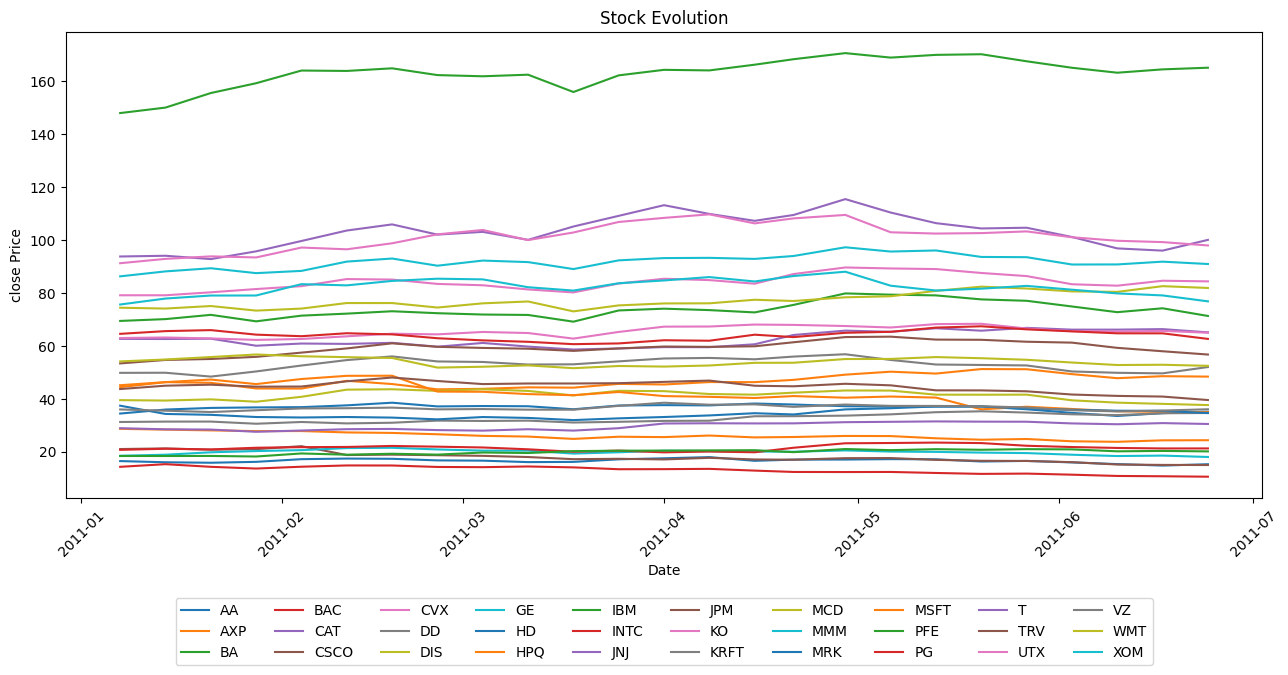

C:\Users\Carolina\AppData\Local\Temp\ipykernel_20864\1012835865.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


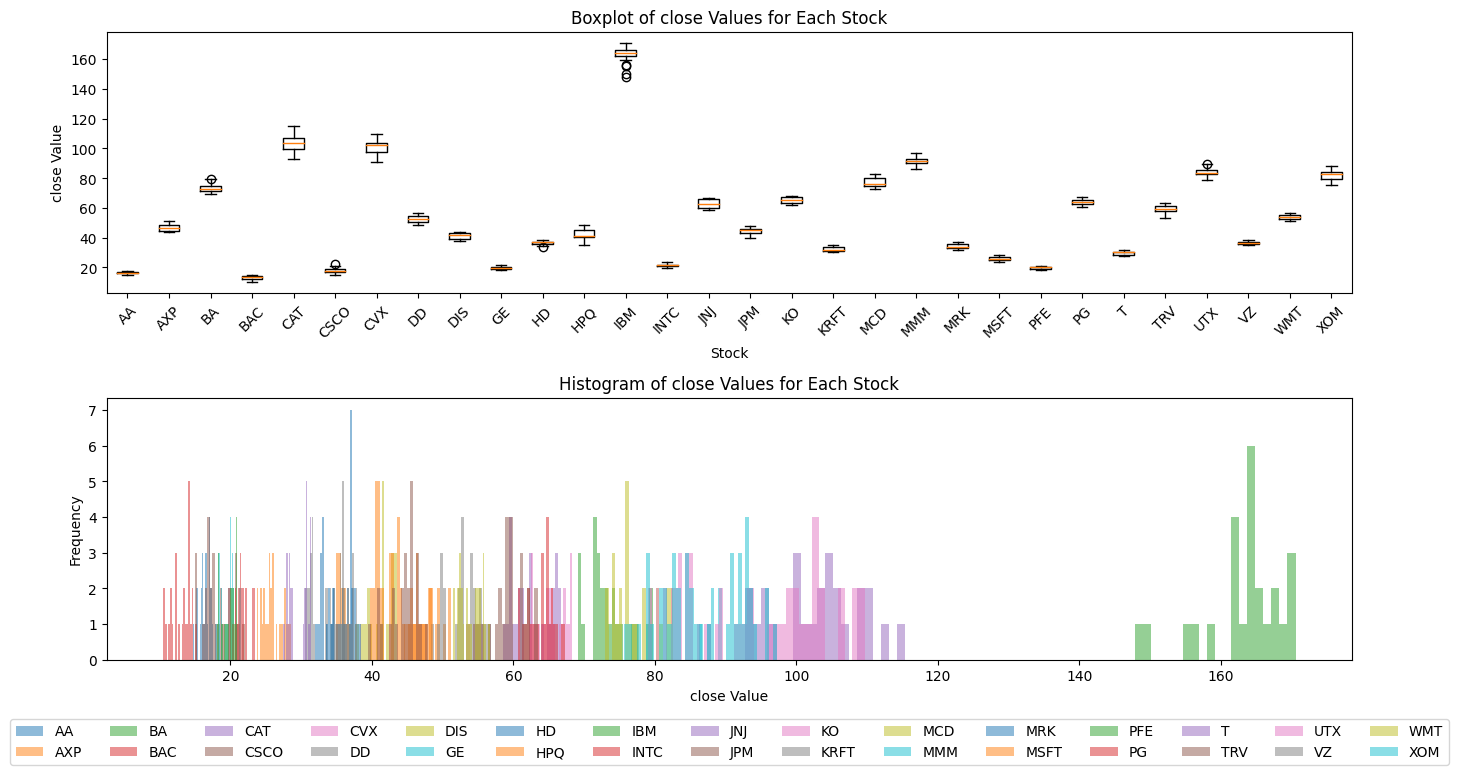

In [32]:
data_evolution_and_distribution('close')

The stock with highest closing values is IBM. It is an outlier in terms of prices.

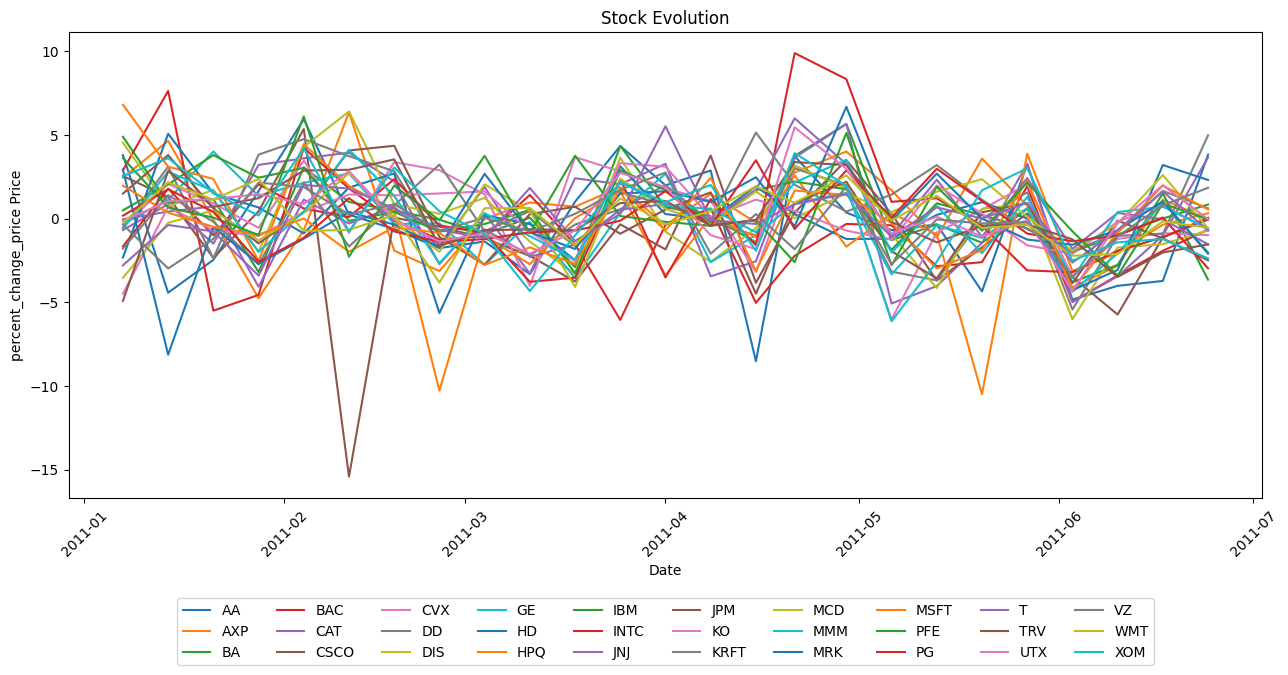

C:\Users\Carolina\AppData\Local\Temp\ipykernel_20864\1012835865.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


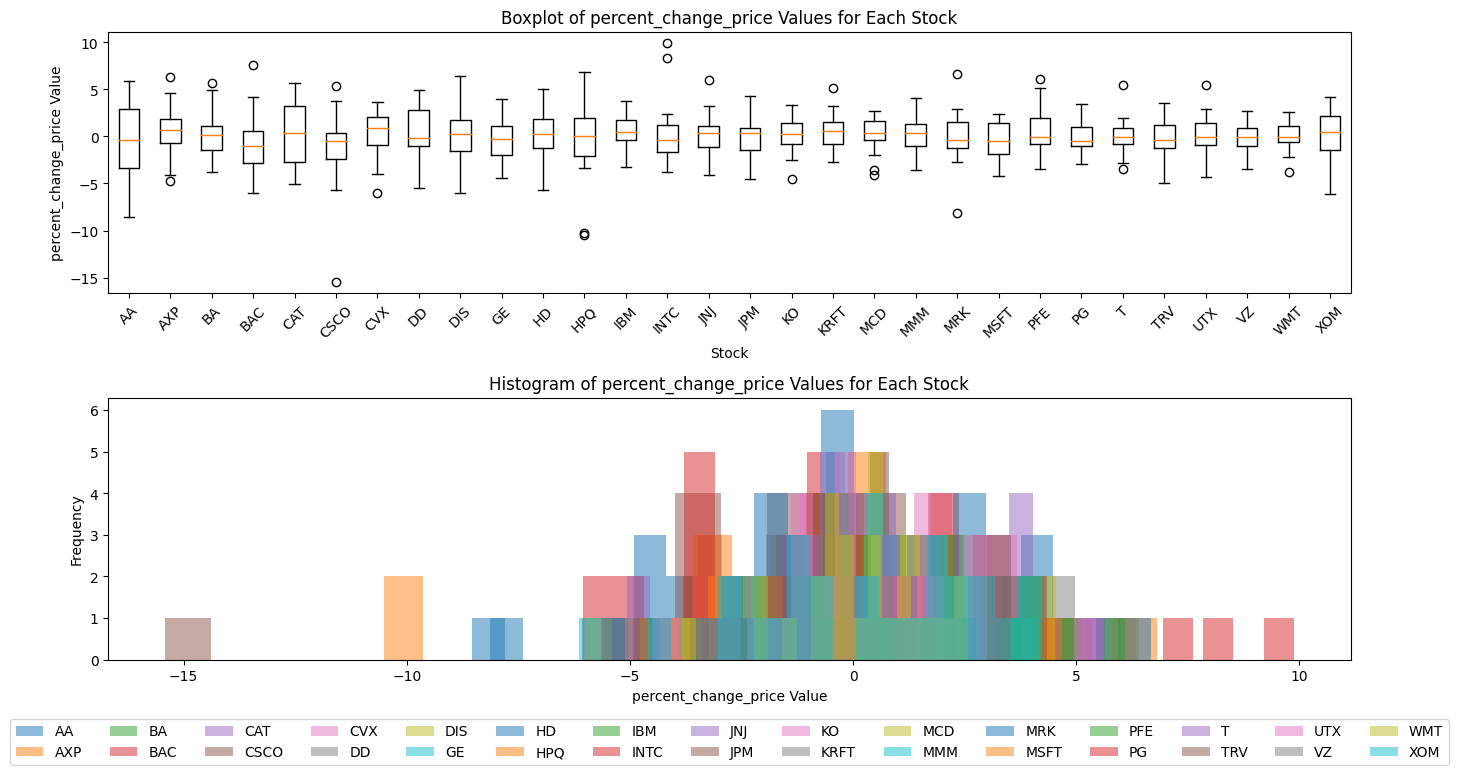

In [33]:
data_evolution_and_distribution('percent_change_price')

The stock with the most negative percentage price changes is CSCO, followed by HPQ. On the contrary, INTC shows the highest percentage price changes of all stocks.

In [34]:
print(f"Count of percent_change_price equal or above 0 is {(df['percent_change_price'] >= 0).sum()}, which represents {((df['percent_change_price'] >= 0).sum()/(df['percent_change_price']).count())*100}%.")
print(f"Count of negative percent_change_price is {(df['percent_change_price'] < 0).sum()}, which represents {((df['percent_change_price'] < 0).sum()/(df['percent_change_price']).count())*100}%.")

Count of percent_change_price equal or above 0 is 377, which represents 50.26666666666667%.
Count of negative percent_change_price is 373, which represents 49.733333333333334%.


In [35]:
# Append all new (derived) variables to the existing list of numerical columns
numerical_cols.extend(['price_change_ratio', 'day_of_week', 'month', 'volume_to_avg_volume_ratio'])

## Feature Selection 

### 1. Correlation Analysis

Highly or perfectly correlated variables should / cannot cannot be considered together for the modelling phase. Why:
 - Perfectly correlated variables means redundant information to the model, leading to multicollinearity. The latter interferes with parameter estimation and increase the variance of the estimates, making the model less reliable.
 - Multicollinearity caused by perfectly correlated variables can make the model coefficients sensitive to small changes in the data -> unstable parameter estimates and model predictions.
 - Perfectly correlated variables can lead to overfitting -> model learns to fit the noise of the train data and is unable to generalize to new unseen data (once it does not learn the data patterns).
 - Highly correlated explanatory vars can lead to singular matrices and prevent the model from converging or producing meaningful results.
 - A highly correlated variable is redundant - it can become a problem to ascertain wich variables are driving the behavior of the model.

Limitations:
 - Only measures the linear relationships between variables (if variables are related non-linearly, it won't capture it)

In [36]:
y_var_name = 'percent_change_next_weeks_price'

In [37]:
def select_top_correlated_variables(df, numerical_cols, y, plot_correlation=False):
    # Create the correlation matrix
    correlation_matrix = df[numerical_cols].corr()

    # Plot correlation matrix if plot_correlation is True
    if plot_correlation:
        plt.figure(figsize=(20, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation Plot of Numerical Variables')
        plt.show()

    # Calculate correlations with y variable: 'percent_change_next_weeks_price'
    correlations_with_y = abs(correlation_matrix[y]).sort_values(ascending=False)
    #print(f"Correlation coefficients with {y}: {correlations_with_y}")

    # Identify pairs of features with high correlation
    highly_correlated_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > 0.8:
                highly_correlated_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

    #print(f"\nAssessing highly correlated variables: \nPairs of features with correlation coefficient > 0.8 or < -0.8 among each other: \n{highly_correlated_pairs}.")

    # Select the top 4 most correlated variables with 'percent_change_next_weeks_price'
    top_correlated_variables = correlations_with_y.index[1:5]
    #print(f"Top 4 most correlated variables with {y}: \n{top_correlated_variables}")

    # Create all possible pairs with the variables from 'top_correlated_variables'
    possible_pairs = list(combinations(top_correlated_variables, 2))

    # Check if any of these pairs match the highly correlated pairs
    conflicting_pairs = []
    for pair in possible_pairs:
        if pair in highly_correlated_pairs:
            conflicting_pairs.append(pair)

    # If conflicting pairs are found, print them
    if conflicting_pairs:
        #print(f"Pairs of selected variables that are highly correlated with each other: {conflicting_pairs}. \nOne variable from each conflicting pair needs to be dropped.")
        return None
    else:
        #print("No conflicting pairs found. All good.")
        return highly_correlated_pairs, top_correlated_variables.to_list()

In [38]:
highly_correlated_pairs, feat_selection_corr = select_top_correlated_variables(df, numerical_cols, 'percent_change_next_weeks_price', plot_correlation=False)
feat_selection_corr

['day_of_week',
 'next_weeks_close',
 'previous_weeks_volume',
 'percent_change_volume_over_last_wk']

### 2. Mutual Information
 - Used for feature Selection by https://www.mdpi.com/2076-3417/14/5/1960

MI notes:
 - Measures the amount of information obtained about one variable through the other variable, i.e., quantifies the amount of information shared between two variables.
 - Works for linear or non-linear relationships.
 - Can be used for continuous and discrete variables.

 - Features with higher MI values provide more information about the target variable (and vice-versa).


In [39]:
def select_top_mi_variables(df, y, cols_to_drop, n):
    """
    Compute Mutual Information (MI) between features and target variable and return the top n features.
    
    Parameters:
    X : DataFrame
        Features DataFrame.
    y : Series
        Target variable Series.
    n : int, optional
        Number of top features to return.
    
    Returns:
    top_features : list
        List of top n features based on MI values.
    """
    # Defining X variables and y variable
    X = df.drop(columns=cols_to_drop)  # All possible exploratory variables, except y, stock and the date columns
    y = df['percent_change_next_weeks_price']  # Target variable

    # Compute Mutual Information
    mi = mutual_info_regression(X, y)
    
    # Combine feature names and MI values
    feature_mi_pairs = zip(X.columns, mi)
    
    # Sort feature-MI pairs by MI values in decreasing order
    sorted_feature_mi_pairs = sorted(feature_mi_pairs, key=lambda x: x[1], reverse=True)
    
    # Get the top n features
    top_features = [feature for feature, mi_value in sorted_feature_mi_pairs[:n]]
    
    return top_features

In [40]:
feat_selection_mi = select_top_mi_variables(df, 'percent_change_next_weeks_price', 
                                            cols_to_drop=['percent_change_next_weeks_price', #output
                                                          'stock', #label of the stock
                                                          'date', #will be the index of the time series
                                                          'next_weeks_open', #future information
                                                          'next_weeks_close' #future information
                                                          ], n=6)

print(f"Top {len(feat_selection_mi)} MI variables: {feat_selection_mi}")

Top 6 MI variables: ['quarter', 'month', 'high', 'close', 'low', 'open']


### 3. Random Forests Feature Importance

In [41]:
from sklearn.ensemble import RandomForestRegressor

def select_top_rfs_variables(df, y, cols_to_drop, n):
    """
    Train a Random Forest model and return the top n features based on feature importance.
    
    Parameters:
    X : DataFrame
        Features DataFrame.
    y : Series
        Target variable Series.
    n : int, optional
        Number of top features to return (default is 4).
    
    Returns:
    top_features : list
        List of top n features based on feature importance.
    """
     # Defining X variables and y variable
    X = df.drop(columns=cols_to_drop)  # All possible exploratory variables, except y, stock and the date columns
    y = df['percent_change_next_weeks_price']  # Target variable


    # Initialize a Random Forest Regressor model
    model = RandomForestRegressor()
    
    # Train the model
    model.fit(X, y)
    
    # Get feature importances
    importances = model.feature_importances_
    
    # Combine feature names and importances
    feature_importance_pairs = zip(X.columns, importances)
    
    # Sort feature-importance pairs by importance values in decreasing order
    sorted_feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)
    
    # Get the top n features
    top_features = [feature for feature, importance in sorted_feature_importance_pairs[:n]]
    
    return top_features

In [42]:
feat_selection_rfs = select_top_rfs_variables(df, 'percent_change_next_weeks_price', 
                                            cols_to_drop=['percent_change_next_weeks_price', #output
                                                          'stock', #label of the stock
                                                          'date', #will be the index of the time series
                                                          'next_weeks_open', #future information
                                                          'next_weeks_close' #future information
                                                          ], n=6)

print(f"Top {len(feat_selection_rfs)} RFs variables: {feat_selection_rfs}")

Top 6 RFs variables: ['percent_change_price', 'percent_return_next_dividend', 'price_change_ratio', 'volume', 'days_to_next_dividend', 'previous_weeks_volume']


### 4. Compare Results of the Three Methods

In [43]:
def find_most_promissing_variables(candidate_vars, highly_correlated_pairs):
    # Initialize a dictionary to store variable counts
    variable_counts = defaultdict(int)

    # Iterate over each array and update the counts in the dictionary
    for array in candidate_vars:
        for var in array:
            variable_counts[var] += 1

    # Filter the dictionary to include only variables that appear in 2 or more arrays
    promissing_variables = {var: count for var, count in variable_counts.items() if count >= 2}

    # Convert the dictionary keys to a list
    promissing_variables_list = list(promissing_variables.keys())

    # If there's only one common variable, no need to check pairs
    if len(promissing_variables_list) == 1:
        return [promissing_variables_list[0]]
    else:
        # Create pairs from the common variables
        common_variable_pairs = list(combinations(promissing_variables_list, 2))

        # Check if any of the pairs are contained in highly_correlated_pairs
        conflicting_pairs = []
        for pair in common_variable_pairs:
            if pair in highly_correlated_pairs:
                conflicting_pairs.append(pair)

    # Print the conflicting pairs
    if conflicting_pairs:
        print("Altough promissing, the following variables are highly correlated and should not be included simultaneously in the modelling phase:")
        for pair in conflicting_pairs:
            print(pair)
    else:
        print(f"The most promissing variables are: {promissing_variables_list}")
        return promissing_variables_list

In [44]:
candidate_vars = [
    feat_selection_corr,
    feat_selection_mi,
    feat_selection_rfs
]

promissing_variables = find_most_promissing_variables(candidate_vars, highly_correlated_pairs)
promissing_variables

['previous_weeks_volume']

In [45]:
df.columns.values

array(['quarter', 'stock', 'date', 'open', 'high', 'low', 'close',
       'volume', 'percent_change_price',
       'percent_change_volume_over_last_wk', 'previous_weeks_volume',
       'next_weeks_open', 'next_weeks_close',
       'percent_change_next_weeks_price', 'days_to_next_dividend',
       'percent_return_next_dividend', 'price_change_ratio',
       'day_of_week', 'month', 'volume_to_avg_volume_ratio'], dtype=object)

## Train Test Split

Can take 2 approaches: The traditional train-test split (with 20/30% of data reserved for testing), or go for cross-validation.
Thoughts:
 - Does it make sense to use CV to train a time series model? I believe not, here's why:
    - I could be using future info to predict past data, which is not correct.
 - Hence, maybe the traditional train-test split is better, being the train data all the data available until the data point I want to predict, making it the test data set (actually data point)

 - I will apply train-test split in the next section (Modelling) 

<font color=#FF0000>**NEED TO WRITE HERE (below)**</font>

-----
*Add here your data understanding findings and conclusions (max. 200 words)*

-----

## Modelling
In this phase, your main goal is to develop and describe your approach to the solution of the problem. Some guidelines to help you:
* What metrics will you use to evaluate your solutions?
* What are some algorithms that can lead to good results? And why?
* Describe in detail your thought process during the development of your solution.
* Present your results.


-----


## Model 1. ARIMA

ARIMA Notes

Index:
 - date variable

Target Variable:
 - percent_change_next_weeks_price: The variable I want to predict.

Exogenous Variables (optional):
 - open, high, low, close, volume, percent_change_price, percent_change_volume_over_last_wk, previous_weeks_volume: Historical values of these variables might provide additional information that could help improve the forecast accuracy. E.g., past price changes, volume changes, etc., could influence future price changes.
 
 - days_to_next_dividend, percent_return_next_dividend: These variables might also be relevant if dividends have an impact on stock prices.

Defining (p, d, q) can be achieved analysing ACF (q) and PACF (p) plots. d is given by the number of times the series needs to be differenciated to become stationary


Early experiments for IBM and/or AA

In [47]:
promissing_variables

['previous_weeks_volume']

In [305]:
df['stock'].unique()

array(['AA', 'AXP', 'BA', 'BAC', 'CAT', 'CSCO', 'CVX', 'DD', 'DIS', 'GE',
       'HD', 'HPQ', 'IBM', 'INTC', 'JNJ', 'JPM', 'KRFT', 'KO', 'MCD',
       'MMM', 'MRK', 'MSFT', 'PFE', 'PG', 'T', 'TRV', 'UTX', 'VZ', 'WMT',
       'XOM'], dtype=object)

In [324]:
#stock_data = df[df['stock'] == 'AA']

In [325]:
stock_data = df[df['stock'] == 'AA'].copy()

# Set the 'date' column as the index
stock_data.set_index('date', inplace=True)

# Set ts data as a univariate ts
ts_data = stock_data[['percent_change_next_weeks_price',
                    'previous_weeks_volume', 
                    'day_of_week', 
                    'close'
                    ]]

### Step 1. Assess Stationarity of the Series
 - Allows to derive the d parameter of ARIMA

In [326]:
# Function to check stationarity

def check_stationarity(series):
    result = adfuller(series)
    p_value = result[1]
    return p_value < 0.05

def perform_adf_and_differencing(multivariate_data):
    stationary_data = pd.DataFrame(index=multivariate_data.index)
    differenced_vars = {var: 0 for var in multivariate_data.columns}
    d_vars = {}

    for var in multivariate_data.columns:
        if check_stationarity(multivariate_data[var]):
            stationary_data[var] = multivariate_data[var]
            d_vars[var] = 0
        else:
            # Perform differencing until stationary
            while not check_stationarity(multivariate_data[var]):
                multivariate_data.loc[:, var] = multivariate_data[var].diff()
                multivariate_data = multivariate_data.dropna()
                differenced_vars[var] += 1
            d_vars[var] = differenced_vars[var]
            stationary_data[var] = multivariate_data[var]
    
    stationary_data = stationary_data.dropna()

    # Print the results
    for var, num_diffs in d_vars.items():
        if num_diffs > 0:
            print(f"Variable {var} wasn't stationary. Total needed differences: {num_diffs}")
        else:
            print(f"Variable {var} is already stationary. Total needed differences: {num_diffs}.")

    return stationary_data, d_vars

In [327]:
stationary_data, d_values = perform_adf_and_differencing(ts_data)
max_d = max(d_values.values())
print(max_d)

Variable percent_change_next_weeks_price wasn't stationary. Total needed differences: 4
Variable previous_weeks_volume is already stationary. Total needed differences: 0.
Variable day_of_week is already stationary. Total needed differences: 0.
Variable close wasn't stationary. Total needed differences: 1
4


### Step 2. Assess ACF and PACF 
 - To derive the other parameters of ARIMA: q and p

In [328]:
# Function to calculate significant ACF and PACF lags for each column
def calculate_significant_lags(ts_data):
    significant_lags = {}
    
    for column in ts_data.columns:
        # Calculate the autocorrelation function (ACF) and partial autocorrelation function (PACF) for the current column
        acf = sm.tsa.acf(ts_data[column], fft=False)
        pacf = sm.tsa.pacf(ts_data[column])
        
        # Determine the significant lags based on the confidence interval (spikes are relevant if their absolute value is above the 95% CI)
        significant_acf_lags = np.where(np.abs(acf) > 1.96)#[0]  
        significant_pacf_lags = np.where(np.abs(pacf) > 1.96)#[0]  
        
        # No significant lags found = 0 lags
        if len(significant_acf_lags) == 0:
            significant_acf_lags = 0
        if len(significant_pacf_lags) == 0:
            significant_pacf_lags = 0
        
        # Store the significant lags for the current column
        significant_lags[column] = {'ACF': significant_acf_lags, 'PACF': significant_pacf_lags}
    
    return significant_lags

In [329]:
significant_lags = calculate_significant_lags(stationary_data)

print("Significant Lags:")
for column, lags in significant_lags.items():
    print(f"\nVariable {column}:")
    print(f"ACF has {len(lags['ACF'][0])} Lags")
    print(f"PACF has {len(lags['PACF'][0])} Lags")

Significant Lags:

Variable percent_change_next_weeks_price:
ACF has 0 Lags
PACF has 3 Lags

Variable previous_weeks_volume:
ACF has 0 Lags
PACF has 0 Lags

Variable day_of_week:
ACF has 0 Lags
PACF has 0 Lags

Variable close:
ACF has 0 Lags
PACF has 0 Lags


In [330]:
# Initialize variables to store the maximum lengths
max_pacf_length = 0
max_acf_length = 0

# Iterate over the dictionary of dictionaries
for var_name, spikes in significant_lags.items():
    pacf_array = spikes['PACF'][0]  # Extract PACF array
    acf_array = spikes['ACF'][0]  # Extract ACF array
    
    # Update maximum lengths if the current lengths are greater
    max_pacf_length = max(max_pacf_length, len(pacf_array))
    max_acf_length = max(max_acf_length, len(acf_array))

# Set p and q to the maximum lengths
max_p = max_pacf_length
max_q = max_acf_length

print("p:", max_p)
print("q:", max_q)

p: 3
q: 0


### Step 3. Train - Test Split and Evaluating the Model

#### 3.1 Train-Test Split
 - The train data will comprise, initially, the first quarter of the data (equivalent to 12 weeks, i.e., 12 rows.)
 - The data will be updated with a new week after the prediction is done

#### 3.2 Try to fit several models with auto.arima and evaluate them
 - Choose the best overall model for the predictions made. 
 - Use auto.arima --> did not work properly, was not attmepting all combinations based on max q,p and d.
 - Grid search "manually"
 - Choose the best model for each prediction.
 - The best overall model is the one that appears the most in the global predicitons. This model will be used later on to provide the prediction of each stock at a given week provided by the client.

#### 3.1 and 3.2: Train - Test Split and Evaluating the Model

In [365]:
# Define the range of hyperparameters to search over
ps = range(0, max_p + 1)  
ds = range(0, max_d + 1)  
qs = range(0, max_q + 1) 

# Set the number of observations for training: we will use 12 records as the mininum (equivalent to using the number of weeks that compose the first quarter for the model to learn)
# Consider the stationary data can have fewer rows than the ts_data (if columns were made stationary)
train_size = 12

# Initialize a dictionary to store the best models and their performance metrics
best_models = {}
experiments = {}

# Initialize a list to store predictions
predictions = []

# Perform a manual grid search over all combinations of hyperparameters
for p, d, q in itertools.product(ps, ds, qs):
    # Iterate over the data
    for i in range(train_size, len(stationary_data)):
        # Extract the training data
        train_data = stationary_data.iloc[:i]  # Include all rows up to the current index i

        try:
            # Fit ARIMA model
            arima_model = ARIMA(train_data['percent_change_next_weeks_price'], 
                                 exog=train_data['close'], 
                                 order=(p, d, q)).fit()

            # Make one-step-ahead prediction
            forecast_value = arima_model.forecast(steps=1, exog=stationary_data['close'][i:i+1].values.reshape(-1, 1))

            # Extract the differencing parameter (d) from the model's order
            if d > 0:
                # Use the last available observation from the original data for undifferencing
                last_observation = ts_data['percent_change_next_weeks_price'].iloc[i-1]
                forecast = forecast_value + last_observation  # Undo differencing
            else:
                forecast = forecast_value

            # Evaluate model performance (you can use any evaluation metric here)
            true_value = ts_data['percent_change_next_weeks_price'].iloc[i]
            mae = np.abs(forecast - true_value)

            # Update the experiments dictionary
            experiments[(p, d, q, i)] = {'model': arima_model, 'forecast': forecast, 'true_value': true_value, 'MAE': mae}

        except:
            # Skip if model fitting fails
            continue

c:\Users\Carolina\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carolina\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carolina\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carolina\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported 

c:\Users\Carolina\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Carolina\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Carolina\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carolina\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index h

In [390]:
# Initialize a dictionary to store the overall results for each predicted observation
overall_results = {}

# Iterate through the experiments dictionary
for params, result in experiments.items():
    forecast_index = params[3]  # Extract the index of the predicted observation
    if forecast_index not in overall_results:
        overall_results[forecast_index] = {'forecasts': [], 'true_values': [], 'MAEs': [], 'models': [], 'p': [], 'd': [], 'q': []}
    
    # Append the forecast, true value, MAE, and model to the corresponding list
    overall_results[forecast_index]['forecasts'].append(result['forecast'])
    overall_results[forecast_index]['true_values'].append(result['true_value'])
    overall_results[forecast_index]['MAEs'].append(result['MAE'])
    overall_results[forecast_index]['models'].append(result['model'])
    overall_results[forecast_index]['p'].append(params[0])
    overall_results[forecast_index]['d'].append(params[1])
    overall_results[forecast_index]['q'].append(params[2])

# overall_results will contain a dictionary for each predicted observation 
# Each dictionary will have keys 'forecasts', 'true_values', 'MAEs', 'models', 'p', 'd', and 'q', containing the corresponding results

In [393]:
# Initialize a dictionary to store the complete row with the lowest MAE for each key
lowest_mae_rows_dict = {}

# Iterate over the keys in overall_results
for key, results in overall_results.items():
    # Get the list of MAEs
    maes_list = results['MAEs']
    
    # Find the index of the lowest MAE
    lowest_mae_index = min(range(len(maes_list)), key=lambda i: maes_list[i].values[0])
    
    # Extract the complete row with the lowest MAE
    lowest_mae_row = {
        'model': results['models'][lowest_mae_index],
        'forecast': results['forecasts'][lowest_mae_index],
        'true_value': results['true_values'][lowest_mae_index],
        'MAE': maes_list[lowest_mae_index],
        'p': results['p'][lowest_mae_index],
        'd': results['d'][lowest_mae_index],
        'q': results['q'][lowest_mae_index]
    }
    
    # Save the complete row with the lowest MAE in the dictionary
    lowest_mae_rows_dict[key] = lowest_mae_row

# Print the dictionary containing the complete row with the lowest MAE for each key
print("Complete rows with lowest MAE for each key:", lowest_mae_rows_dict)

Complete rows with lowest MAE for each key: {12: {'model': <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x00000222E29443D0>, 'forecast': 12   -1.930972
dtype: float64, 'true_value': 0.88544, 'MAE': 12    2.816412
dtype: float64, 'p': 0, 'd': 0, 'q': 0}, 13: {'model': <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x00000222E7466890>, 'forecast': 13   -11.622395
dtype: float64, 'true_value': -11.39739, 'MAE': 13    0.225005
dtype: float64, 'p': 2, 'd': 1, 'q': 0}, 14: {'model': <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x00000222E766FE50>, 'forecast': 14    11.00867
dtype: float64, 'true_value': 12.25574, 'MAE': 14    1.24707
dtype: float64, 'p': 2, 'd': 3, 'q': 0}, 15: {'model': <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x00000222E7961A50>, 'forecast': 15   -3.502188
dtype: float64, 'true_value': -3.374419, 'MAE': 15    0.127769
dtype: float64, 'p': 3, 'd': 1, 'q': 0}, 16: {'model': <statsmodels.tsa.arima.model.ARIMAResultsWra

In [402]:
# Create a Counter to count the occurrences of each (p, d, q) tuple
params_counter = Counter((result['p'], result['d'], result['q']) for result in lowest_mae_rows_dict.values())

# Find the most common parameters
most_common_params = params_counter.most_common()

# Initialize variables to track the winning parameters
winning_params = None
winning_count = 0

# Iterate over the most common parameters
for params, count in most_common_params:
    # Update winning parameters if the current count is higher
    if count > winning_count:
        winning_params = [params]  # Store the current params as the winning candidates
        winning_count = count
    elif count == winning_count:
        winning_params.append(params)  # Add the params to the list of winning candidates

# If there is a "major" count, save those parameters
if len(winning_count==1):
    selected_params = winning_params
else:
    # Find the lowest MAE tied tuples
    lowest_mae_tied_tuples = [(result['MAE'].values[0], params) for params, count in most_common_params if count == winning_count]
    
    # Sort by MAE to find the tuple with the lowest MAE among the tied ones
    lowest_mae_tied_tuples.sort()
    
    # Select the parameters with the lowest MAE among the tied tuples
    selected_params = lowest_mae_tied_tuples[0][1]

print("Selected Parameters:", selected_params)

Selected Parameters: [(2, 1, 0)]


In [425]:
import numpy as np

# Initialize a dictionary to store the matching rows for each key
matching_rows = {}

# Initialize lists to store all MAE values of the best parameters model (to all predicted values)
all_mae_values = []

# Initialize variables to count the number of times the prediction has the same sign as the true value
total_predictions = 0
same_sign_count = 0

# Iterate over the keys in overall_results
for key, results in overall_results.items():
    # Find the indices where p=2, d=1, and q=0
    indices = [i for i, (p, d, q) in enumerate(zip(results['p'], results['d'], results['q'])) if p == 2 and d == 1 and q == 0]
    
    # Store the matching rows for the current key
    matching_rows[key] = [{
        'forecast': results['forecasts'][index],
        'true_value': results['true_values'][index],
        'MAE': results['MAEs'][index],
    } for index in indices]
    
    # Extract the MAE values from each row and add them to the all_mae_values list
    all_mae_values.extend([row['MAE'].values[0] for row in matching_rows[key]])
    
    # Iterate over each row in the list of matching rows
    for row in matching_rows[key]:
        # Increment the total number of predictions
        total_predictions += 1

        # Extract the forecast and true value
        forecast = row['forecast'].values[0]
        true_value = row['true_value']

        # Check if the signs are the same
        if np.sign(forecast) == np.sign(true_value):
            same_sign_count += 1

# Calculate the average and median of the MAE values
average_mae = np.mean(all_mae_values)
median_mae = np.median(all_mae_values)
max_mae = np.max(all_mae_values)
min_mae = np.min(all_mae_values)

# Calculate the percentage of times the prediction has the same sign as the true value
if total_predictions > 0:
    same_sign_percentage = (same_sign_count / total_predictions) * 100
else:
    same_sign_percentage = 0

# Print the results
print("All MAE values:", all_mae_values)
print("Average MAE:", average_mae)
print("Median MAE:", median_mae)
print("Max MAE:", max_mae)
print("Min MAE:", min_mae)
print("Percentage of times the prediction has the same sign as the true value: {:.2f}%".format(same_sign_percentage))

All MAE values: [68.31120985931044, 0.2250050597932134, 12.350132501623715, 15.950308631945912, 35.9576625666923, 49.372092638782526, 25.368958683060637, 0.300417487372572]
Average MAE: 25.979473428572664
Median MAE: 20.659633657503274
Max MAE: 68.31120985931044
Min MAE: 0.2250050597932134
Percentage of times the prediction has the same sign as the true value: 50.00%


The model predicts well if the percent_change_next_weeks_price will be positive or negative 50% of the time. This means that using the model is as good as guessing.

The selected_params will be used as the parameters of the Arima model that will be used by the Client to predict the stock provided at the date provided.

### Let the Client choose a date for the best overall model to predict 
- Still needs to be done (the part of being the best overall from the code above. Now just has a random model appointed by me)

In [413]:
# Try to create functions to predict the data point provided by the user (through the date)
def arima_forecast_no_exog(stock_data, prediction_date, previous_index_to_prediction, selected_params):
    # Define the training observations and the target variable
    y_train = stock_data.loc[:previous_index_to_prediction][y_var_name]
    y_test = stock_data.loc[previous_index_to_prediction][y_var_name]
    
    # Fit an ARIMA model without exogenous variables
    model = ARIMA(y_train, order=selected_params[0])
    arima_model = model.fit()

    # Predict future values
    future_forecast = arima_model.forecast(steps=1)
    
    predicted_value = ts_data.loc[previous_index_to_prediction][y_var_name]  + future_forecast
    #predicted_value = ts_data.loc[previous_index_to_prediction][y_var_name] + future_forecast + d_values['percent_change_next_weeks_price']
    y_true = ts_data[y_var_name].loc[prediction_date]

    return predicted_value, y_true


def arima_forecast_with_exog(stock_data, prediction_date, previous_index_to_prediction, selected_params, exog_vars):
    # Define exogenous variables
    train_exog = stock_data.loc[:previous_index_to_prediction][exog_vars]
    test_exog = stock_data.loc[previous_index_to_prediction][exog_vars]
    test_exog_array = np.array(test_exog).reshape(1, -1)
    
    # Define the target variable
    y_train = stock_data.loc[:previous_index_to_prediction][y_var_name]
    y_test = stock_data.loc[previous_index_to_prediction][y_var_name]

    # Fit an ARIMA model with exogenous variables
    model = ARIMA(y_train, order=selected_params[0], exog=train_exog)
    arima_model = model.fit()

    # Predict future values
    future_forecast = arima_model.forecast(steps=1, exog=test_exog_array)

    predicted_value = ts_data.loc[previous_index_to_prediction][y_var_name] + future_forecast    
    #predicted_value = ts_data.loc[previous_index_to_prediction][y_var_name] + future_forecast + d_values['percent_change_next_weeks_price']
    y_true = ts_data[y_var_name].loc[prediction_date]

    return predicted_value, y_true


def arima_forecast(stock_data, prediction_date, previous_index_to_prediction, selected_params, exog_vars=None):
    if exog_vars is None or len(exog_vars) == 0:
        return arima_forecast_no_exog(stock_data, prediction_date, previous_index_to_prediction, selected_params)
    else:
        return arima_forecast_with_exog(stock_data, prediction_date, previous_index_to_prediction, selected_params, exog_vars)

# No need for the code below, stationary data will have the right columns (either differenced or not)

prediction_date = '2011-04-01'#'2011-06-17'#'2011-06-24'#'2011-06-03'
previous_index_to_prediction = ts_data.index[ts_data.index < prediction_date].max()

exog_vars = ['close'] #[] 
d_count=0

#if y_series is not stationary, the series we need to pass will always need to be the stationary one
if d_values[y_var_name]>0: 
    # 2 possible cases
    if exog_vars: #1: there are exogenous variables
        future_forecast, y_true = arima_forecast(stationary_data, prediction_date, previous_index_to_prediction, exog_vars=exog_vars)
    else: #2: there are no exogenous variables   
        future_forecast, y_true = arima_forecast(stationary_data, prediction_date, previous_index_to_prediction)

#our y_series is stationary        
else: 
    # 2 possible main cases
    if exog_vars: #If we want to include exogenous variables in the model
        for var in exog_vars: #Run thorough all exog_vars
            d_count=+d_values[var] # d_count will sum the d_values of each exogenous variable we want to introduce in the model
        # If at least one of the variables needed differencing    
        if d_count>0: 
            #Apply the stationary data and exog model
            future_forecast, y_true = arima_forecast(stationary_data, prediction_date, previous_index_to_prediction, exog_vars=exog_vars)
        else:
            #Otherwise, we can use the original series and pass only the exog variables
            future_forecast, y_true = arima_forecast(ts_data, prediction_date, previous_index_to_prediction, exog_vars=exog_vars)
    # If y_series is stationary and we do not want exogenous variables:       
    else:
        future_forecast, y_true = arima_forecast(ts_data, prediction_date, previous_index_to_prediction)

<font color=#FF0000>**Need to adjust the functions below. The predictions are always being corrected, independently of the series being differenced or not. Needs to be based on d_values or the parameter d of selected_params - analyse which is the most correct tomorrow**</font>

In [415]:
prediction_date = '2011-06-17'#'2011-04-01'#'2011-06-17'#'2011-06-24'#'2011-06-03'
previous_index_to_prediction = ts_data.index[ts_data.index < prediction_date].max()

future_forecast, y_true = arima_forecast(stationary_data, prediction_date, previous_index_to_prediction, selected_params)
print(future_forecast, y_true)

future_forecast, y_true = arima_forecast(stationary_data, prediction_date, previous_index_to_prediction, selected_params, exog_vars=['close'])
print(future_forecast, y_true)

18    22.994031
dtype: float64 7.54524
(2, 1, 0)
18    21.131758
dtype: float64 7.54524


c:\Users\Carolina\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carolina\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carolina\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carolina\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported 

## SARIMA

In [63]:
# Define seasonal lags to test - 1,2 and 3 weeks
seasonal_lags = [1, 2, 3]  # You can adjust these values based on the frequency of your data

# Apply differencing for each seasonal lag and plot
plt.figure(figsize=(10, 6))
plt.plot(ibm_data['date'], ibm_data['percent_change_next_weeks_price'], label='Original', marker='o', linestyle='-')

for lag in seasonal_lags:
    ibm_data[f'diff_{lag}_percent_change'] = ibm_data['percent_change_next_weeks_price'].diff(periods=lag)
    plt.plot(ibm_data['date'], ibm_data[f'diff_{lag}_percent_change'], label=f'{lag}-day Seasonal Difference', marker='o', linestyle='-')

plt.title('IBM Stock Seasonal Differences')
plt.xlabel('Date')
plt.ylabel('Percent Change Next Weeks Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

KeyError: 'date'

<Figure size 1000x600 with 0 Axes>

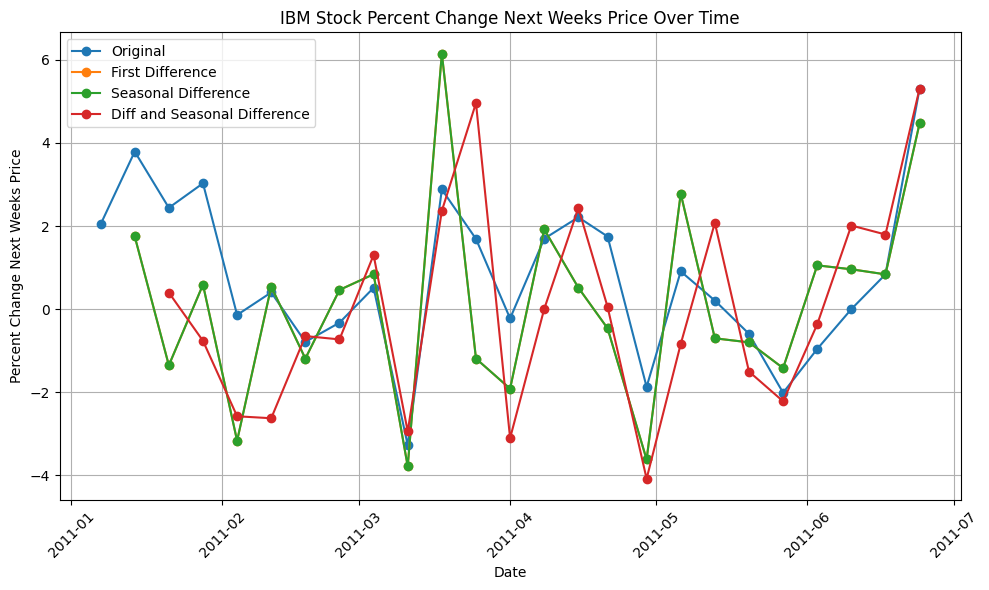

In [133]:
# Perform one difference
ibm_data['diff_percent_change'] = ibm_data['percent_change_next_weeks_price'].diff()

# Perform seasonal difference (weekly seasonality)
ibm_data['seasonal_diff_percent_change'] = ibm_data['percent_change_next_weeks_price'].diff(periods=1)

ibm_data['diss_and_seasonal_diff_percent_change'] = ibm_data['percent_change_next_weeks_price'].diff(periods=2)

# Plot original series, series with one difference, and series with one seasonal difference
plt.figure(figsize=(10, 6))
plt.plot(ibm_data['date'], ibm_data['percent_change_next_weeks_price'], label='Original', marker='o', linestyle='-')
plt.plot(ibm_data['date'], ibm_data['diff_percent_change'], label='First Difference', marker='o', linestyle='-')
plt.plot(ibm_data['date'], ibm_data['seasonal_diff_percent_change'], label='Seasonal Difference', marker='o', linestyle='-')
plt.plot(ibm_data['date'], ibm_data['diss_and_seasonal_diff_percent_change'], label='Diff and Seasonal Difference', marker='o', linestyle='-')

plt.title('IBM Stock Percent Change Next Weeks Price Over Time')
plt.xlabel('Date')
plt.ylabel('Percent Change Next Weeks Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Conclusions: 1 difference provides the same results as 1 seasonal difference.
Interpretation: When one difference provides similar results as one seasonal difference, it suggests that the seasonality in the data is adequately captured by the simple differencing process, i.e., no need to do seasonal ARIMA.

Main Conclusion: No need to apply SARIMA. Apply ARIMA, it is the most adequate of them both.

## LSTM

Formulizing an idea for later (not the dates of the data, but that is not relevant to formulize the idea)
I want to predict the 01/04/2024:
 - Set X_train and y_train to be all days until 31/03/2024 
 - Set X_test and X_test to be 01/04/2024

 - percent_change_next_weeks_price will be the y, train for training dates and test for pred date 
 - X_train will be other variables, explanatory ones.


In [ ]:
#add here your modelling code

-----
*Add here your modelling results and conclusions (max. 200 words)*

-----

## Conclusions
In the conclusions, you should enumerate the results you got after completing the challenge.
* How good do you consider your results? 
* What are some factors that would contribute to get better results?
* What are some advantages and disadvantages of your solution?
* What can be done as future work to improve your results?


-----
*Add here your final conclusions (max. 400 words)*

-----

#### Feedback

-----
*Add here your thoughts and feedback regarding this challenge.*

-----

To submit your solution you should e-mail us this notebook in response to the e-mail you initially received with the challenge.